# Forward Scattering code with HPS
Notebook objective: make sure I (Olivia) understand how to use the HPS code
1. (Completed) Run the HPS code on a provided scattering potential
2. (In progress) Run the HPS code on a scattering potential from our other dataset
3. (To do) Prepare to transfer into the other code base... do I need to precompute interpolation operations? Also need to convert `u_scat` from the grid to the far-field measurements.

In [1]:
import os
import jax
import jax.numpy as jnp
from scipy.io import savemat
import matplotlib.pyplot as plt

import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

from examples.wave_scattering_utils import (
    solve_scattering_problem,
    load_SD_matrices,
    get_uin,
)
from examples.scattering_potentials import (
    q_gaussian_bumps,
)
from examples.plotting_utils import plot_field_for_wave_scattering_experiment

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)

2025-06-19 17:14:19.393:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-19 17:14:19.395:jaxhps: DEBUG - Creating converter from 5 to 7
2025-06-19 17:14:19.396:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-19 17:14:19.397:jaxhps: DEBUG - Creating converter from 5 to 7


## Provided scattering potential

In [2]:
# Basic problem dimensions
k_str = "20"
k = float(k_str)

L = 4
p = 8 # chebyshev order
pm2 = p-2 # gauss-legendre order
n = 192
nside = 2**L

q_fn_handle = q_gaussian_bumps
domain_bounds = jnp.array([-1., 1., -1., 1.])
source_dirs = jnp.linspace(0, 2*jnp.pi, 30)

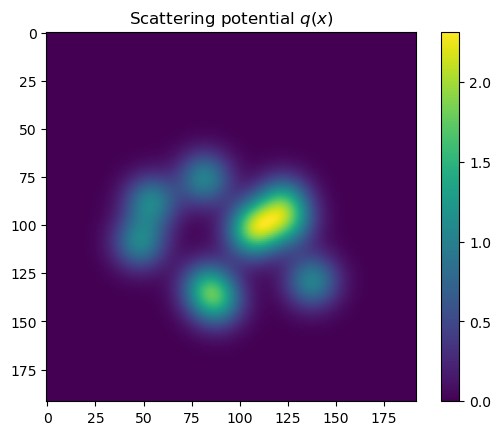

In [3]:
# Visualize the scattering potential in question
mesh_x = jnp.linspace(domain_bounds[0], domain_bounds[1], n)
mesh_y = jnp.linspace(domain_bounds[1], domain_bounds[2], n)
mesh_xy = jnp.array(jnp.meshgrid(mesh_x, mesh_y)).T
q_val = q_fn_handle(mesh_xy)

plt.title(f"Scattering potential $q(x)$")
plt.imshow(q_val, cmap="viridis")
plt.colorbar()
plt.show()

In [4]:
# Load S and D matrices for the boundary integral equation
S_D_matrices_fp = os.path.join(
    "data/wave_scattering/SD_matrices",
    f"SD_k{k_str}_n{pm2}_nside{nside}_dom1.mat"
)
S, D = load_SD_matrices(S_D_matrices_fp)

In [5]:
uscat, target_pts, solve_time = solve_scattering_problem(
    l=L,
    p=p,
    n=n,
    k=k,
    q_fn=q_fn_handle,
    domain_bounds=domain_bounds,
    source_dirs=source_dirs,
    S=S,
    D=D,
)
print(f"Solve time: {solve_time:.2f}s")

2025-06-19 17:14:21.340:jaxhps: INFO - solve_scattering_problem: Creating tree...
2025-06-19 17:14:22.867:jaxhps: DEBUG - solve_scattering_problem: i_term shape: (256, 64)
2025-06-19 17:14:23.367:jaxhps: DEBUG - solve_scattering_problem: source_term shape: (256, 64, 30)
2025-06-19 17:14:23.369:jaxhps: DEBUG - solve_scattering_problem: S device: {CudaDevice(id=0)}
2025-06-19 17:14:33.919:jaxhps: INFO - Finished setting up the PDEProblem object
2025-06-19 17:14:33.924:jaxhps: INFO - Starting local solve
2025-06-19 17:14:33.925:jaxhps: DEBUG - local_solve_stage_uniform_2D_ItI: started. device=cuda:0
2025-06-19 17:14:35.040:jaxhps: INFO - Finished local solve; starting merge stage
2025-06-19 17:14:35.040:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: started. device=cuda:0
2025-06-19 17:14:35.041:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 24, 24)
2025-06-19 17:14:42.221:jaxhps: INFO - Finished merge stage
2025-06-19 17:14:42.446:jaxhps: INFO - Got DtN from ItI
2025-06-19 

Solve time: 46.63s


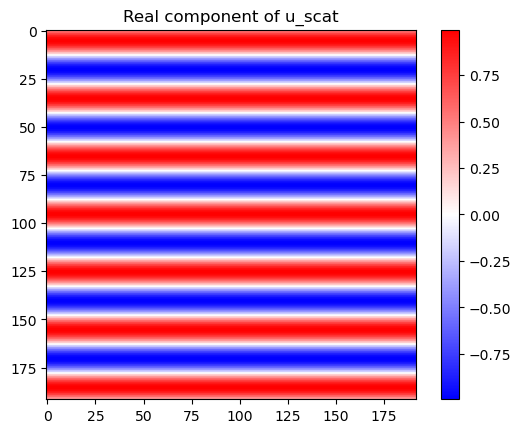

In [6]:
uin = get_uin(k, mesh_xy, source_dirs)

plt.title(f"Real component of u_scat")
plt.imshow(uin[:,:,0].real, cmap="bwr")
plt.colorbar()
plt.show()

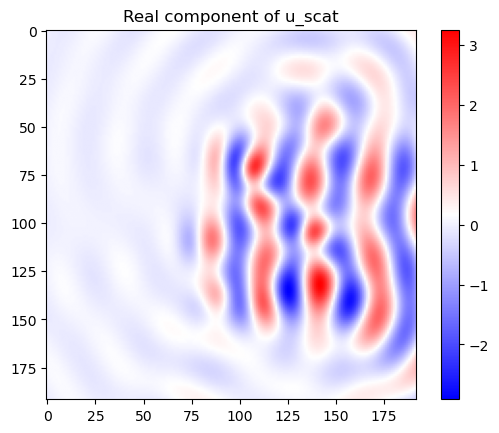

In [7]:
plt.title(f"Real component of u_scat")
plt.imshow(uscat[:,:,0].real, cmap="bwr")
plt.colorbar()
plt.show()

In [8]:
from jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from jaxhps.merge import merge_stage_uniform_2D_ItI
from jaxhps.down_pass import down_pass_uniform_2D_ItI
from timeit import default_timer
from examples.wave_scattering_utils import (
    get_DtN_from_ItI,
    setup_scattering_lin_system,
    get_uin_and_normals,
    get_uin,
    get_scattering_uscat_impedance,
)
from src.jaxhps import (
    Domain as MyDomain,
    DiscretizationNode2D as MyDiscretizationNode2D
)
from src.jaxhps._grid_creation_2D import rearrange_indices_ext_int as rearrange_indices_ext_int_2D
from jaxhps.quadrature import barycentric_lagrange_interpolation_matrix_2D, chebyshev_points
INTERP_BATCH_SIZE = 20

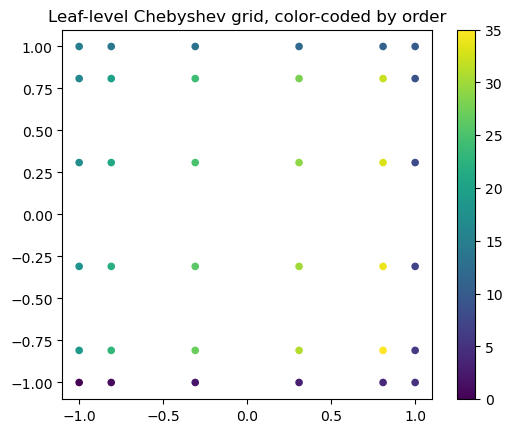

In [9]:
plt.title(f"Leaf-level Chebyshev grid, color-coded by order")
leaf_root = DiscretizationNode2D(-1., 1., -1., 1.)
leafp = 6
leaf_domain = Domain(p=leafp, q=leafp-2, root=leaf_root, L=0)
plt.scatter(*leaf_domain.interior_points.reshape(-1, 2).T, s=20, c=jnp.arange(leafp**2 * 4**0))
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

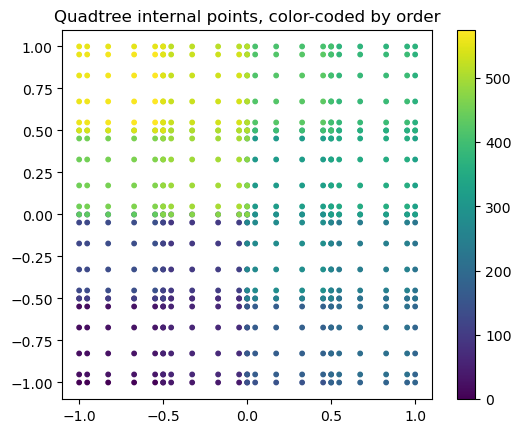

In [10]:
plt.title(f"Quadtree internal points, color-coded by order")
smallp = 6
small_domain_pts = Domain(p=smallp, q=smallp-2, root=leaf_root, L=2).interior_points
plt.scatter(*small_domain_pts.reshape(-1,2).T, s=10, c=jnp.arange(small_domain_pts.size//2))
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [11]:
def reorder_leaves_recursive(leaf_data: jax.Array, new_order: tuple=(3,2,0,1), L: int=None):
    """Recursively reorder the leaves in the requested order
    This function assumes that the provided data has the leaf index as the first axis.
    Suppose the inputs have children in labeled as [0,1,2,3]
        +-----+-----+-----+-----+
        |  0  |  1  |  2  |  3  |
        +-----+-----+-----+-----+
    This function will re-order the children within the flattened structure.
    For example, setting new_order=(3,2,0,1) would result in
        +-----+-----+-----+-----+
        |  3  |  2  |  0  |  1  |
        +-----+-----+-----+-----+
    which, in the quadtree, corresponds to an spatial organization of
        +-----+-----+
        |  3  |  2  |
        +-----+-----+
        |  0  |  1  |
        +-----+-----+
    in terms of the input.
    Note: this function can be used to put the quadtree into Morton or Z order, but this
    is different from row-major order, as far as the blocks are concerned.

    Parameters:
        leaf_data (jax.Array): leaf data with shape (4**L, ...)
            the first axis indexes the different leaves, while successive axes are free
        L (int): number of levels in the quadtree
        new_order (tuple of ints): new relative ordering of the leaves
    Output:
        reordered_data (jax.array): re-ordered leaf data with shape (4**L, ...)
    """
    data_shape = leaf_data.shape
    extras_shape = data_shape[1:]
    L = L if L is not None else int(jnp.round(jnp.log2(data_shape[0])/2))
    new_order_array = jnp.array(new_order)
    tmp_data = jnp.copy(leaf_data)
    idcs = jnp.arange(data_shape[0])
    for l in range(0, L):
        idcs = idcs.reshape(4**l, 4, 4**(L-l-1))
        idcs = jnp.take(idcs, new_order_array, axis=1)
    reordered_data = jnp.take(leaf_data, idcs.flatten(), axis=0)
    return reordered_data

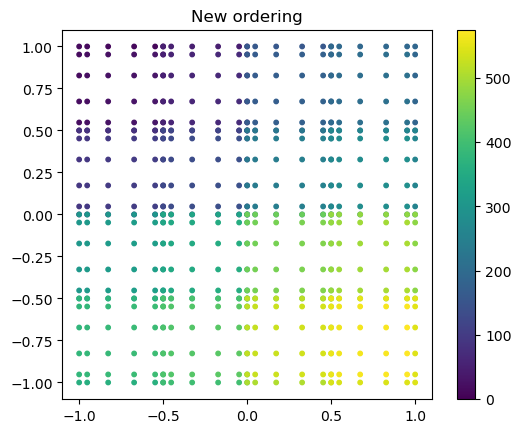

In [12]:
reordered_domain_pts = reorder_leaves_recursive(small_domain_pts, new_order=(3,2,0,1))
plt.title(f"New ordering")
plt.scatter(*reordered_domain_pts.reshape(-1,2)[:].T, s=10, c=jnp.arange(reordered_domain_pts.size//2)[:])
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [13]:
def morton_to_flatten_indices(L, s, return_flat=True):
    """Largely lifted from Matt Li's code; for my purposes s=1 seems sufficient"""
    if L==0:
        res = jnp.arange(s**2).reshape(s,s) # no re-ordering necessary
    else:
        bsize = 4**(L-1) * s**2 # block size
        tmp = morton_to_flatten_indices(L-1, s, return_flat=False) # recurrence
        res = jnp.block([[tmp, tmp+bsize], [tmp+2*bsize, tmp+3*bsize]])
    return res.flatten() if return_flat else res

# TODO: combine reorder_leaves_recursive with morton_to_flat_indices

In [14]:
flattened_domain_pts = jnp.take(reordered_domain_pts, morton_to_flatten_indices(L=2, s=1), axis=0)

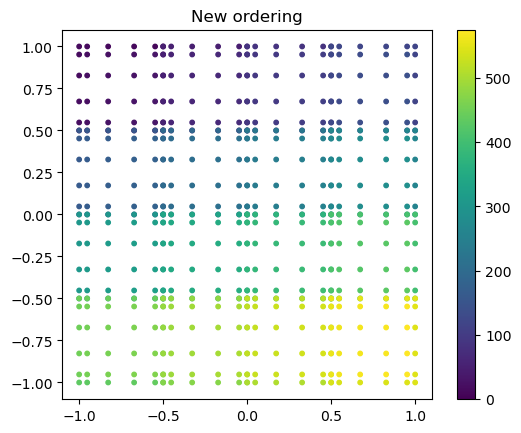

In [15]:
plt.title(f"New ordering")
plt.scatter(*flattened_domain_pts.reshape(-1,2)[:].T, s=10, c=jnp.arange(flattened_domain_pts.size//2)[:])
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [16]:
# copy-and-pasted version of solve_scattering_problem so I can inspect intermediate states
q_fn = q_fn_handle

logging.info("solve_scattering_problem: Creating tree...")
xmin, xmax, ymin, ymax = domain_bounds
root = MyDiscretizationNode2D(
    xmin=float(xmin), xmax=float(xmax), ymin=float(ymin), ymax=float(ymax)
)

domain = MyDomain(p=p, q=p-2, root=root, L=L)

# Evaluate the coefficients and source term for the wave scattering problem
d_xx_coeffs = jnp.ones_like(domain.interior_points[:, :, 0])
d_yy_coeffs = jnp.ones_like(domain.interior_points[:, :, 0]) # [:, :, 1]?
i_term = k**2 * (1 + q_fn(domain.interior_points))
logging.debug("solve_scattering_problem: i_term shape: %s", i_term.shape)

uin_evals = get_uin(k, domain.interior_points, source_dirs)

source_term = (
    -1 * (k**2) * q_fn(domain.interior_points)[..., None] * uin_evals
)
logging.debug(
    "solve_scattering_problem: source_term shape: %s", source_term.shape
)

logging.debug("solve_scattering_problem: S device: %s", S.devices())

t = PDEProblem(
    domain=domain,
    D_xx_coefficients=d_xx_coeffs,
    D_yy_coefficients=d_yy_coeffs,
    I_coefficients=i_term,
    source=source_term,
    use_ItI=True,
    eta=k,
)
logging.info(f"Finished setting up the PDEProblem object")
t_0 = default_timer()

# Determine whether we need to use fused functions or can fit everything on the
n_leaves = domain.n_leaves
chunksize = local_solve_chunksize_2D(p, jnp.complex128)

bool_use_recomp = chunksize < n_leaves

if bool_use_recomp:
    T_ItI = upward_pass_subtree(
        pde_problem=t,
        subtree_height=6,
        compute_device=jax.devices()[0],
        host_device=jax.devices()[0],
    )
else:
    logging.info(f"Starting local solve")
    Y_arr, T_arr, v_arr, h_arr = local_solve_stage_uniform_2D_ItI(
        pde_problem=t,
        host_device=jax.devices()[0],
        device=jax.devices()[0],
    )
    logging.info("Finished local solve; starting merge stage")
    S_arr_lst, g_tilde_lst, T_ItI = merge_stage_uniform_2D_ItI(
        T_arr=T_arr,
        h_arr=h_arr,
        l=domain.L,
        device=jax.devices()[0],
        host_device=jax.devices()[0],
        return_T=True,
    )
    logging.info(f"Finished merge stage")

T_DtN = get_DtN_from_ItI(T_ItI, t.eta)
logging.info(f"Got DtN from ItI")

logging.info(
    "solve_scattering_problem: Solving boundary integral equation..."
)

if jax.devices()[0] not in S.devices():
    S = jax.device_put(S, jax.devices()[0])
    D = jax.device_put(D, jax.devices()[0])
    bool_delete_SD = True
else:
    bool_delete_SD = False
incoming_imp_data = get_scattering_uscat_impedance(
    S=S,
    D=D,
    T=T_DtN,
    source_dirs=source_dirs,
    bdry_pts=t.domain.boundary_points,
    k=k,
    eta=k,
)

logging.info("Finished calculating incoming impedance data")

# Delete exterior matrices we no longer need
T_ItI.delete()
T_DtN.delete()
if bool_delete_SD:
    S.delete()
    D.delete()
logging.info("Deleted exterior matrices; starting to propagate the impedance data")

# Propagate the resulting impedance data down to the leaves
if bool_use_recomp:
    uscat_soln = downward_pass_subtree(
        pde_problem=t,
        boundary_data=incoming_imp_data,
        subtree_height=6,
        compute_device=jax.devices()[0],
        host_device=jax.devices()[0],
    )
else:
    uscat_soln = down_pass_uniform_2D_ItI(
        boundary_data=incoming_imp_data,
        S_lst=S_arr_lst,
        g_tilde_lst=g_tilde_lst,
        Y_arr=Y_arr,
        v_arr=v_arr,
        device=jax.devices()[0],
        host_device=jax.devices()[0],
    )

# Interpolate the solution onto a regular grid with n points per dimension
logging.info(
    "solve_scattering_problem: Interpolating solution onto regular grid..."
)
xvals_reg = jnp.linspace(xmin, xmax, n)
yvals_reg = jnp.linspace(ymin, ymax, n)

n_src = source_dirs.shape[0]

uscat_regular = jnp.zeros(
    (n, n, n_src), dtype=jnp.complex128, device=jax.devices("cpu")[0]
)

# Do the interpolation from HPS to regular grid in batches of size INTERP_BATCH_SIZE
# along the source dimension
for i in range(0, n_src, INTERP_BATCH_SIZE):
    chunk_start = i
    chunk_end = min((i + INTERP_BATCH_SIZE), n_src)
    logging.debug(
        "solve_scattering_problem: Interpolating chunk i=%s, %s:%s",
        i,
        chunk_start,
        chunk_end,
    )
    uscat_i = uscat_soln[..., chunk_start:chunk_end]
    logging.debug(
        "solve_scattering_problem: uscat_i.devices()=%s", uscat_i.devices()
    )
    chunk_i, target_pts = domain.interp_from_interior_points(
        samples=uscat_i, eval_points_x=xvals_reg, eval_points_y=yvals_reg
    )

    chunk_i = jax.device_put(chunk_i, jax.devices("cpu")[0])
    uscat_regular = uscat_regular.at[..., chunk_start:chunk_end].set(
        chunk_i
    )

uscat_regular.block_until_ready()

t_1 = default_timer() - t_0
# return uscat_regular, target_pts, t_1
print(f"Finished in {t_1:.2f}s")

2025-06-19 17:15:25.732:jaxhps: INFO - solve_scattering_problem: Creating tree...
2025-06-19 17:15:26.600:jaxhps: DEBUG - solve_scattering_problem: i_term shape: (256, 64)
2025-06-19 17:15:26.603:jaxhps: DEBUG - solve_scattering_problem: source_term shape: (256, 64, 30)
2025-06-19 17:15:26.604:jaxhps: DEBUG - solve_scattering_problem: S device: {CudaDevice(id=0)}
2025-06-19 17:15:26.617:jaxhps: INFO - Finished setting up the PDEProblem object
2025-06-19 17:15:26.618:jaxhps: INFO - Starting local solve
2025-06-19 17:15:26.618:jaxhps: DEBUG - local_solve_stage_uniform_2D_ItI: started. device=cuda:0
2025-06-19 17:15:26.626:jaxhps: INFO - Finished local solve; starting merge stage
2025-06-19 17:15:26.628:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: started. device=cuda:0
2025-06-19 17:15:26.629:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 24, 24)
2025-06-19 17:15:26.652:jaxhps: INFO - Finished merge stage
2025-06-19 17:15:26.654:jaxhps: INFO - Got DtN from ItI
2025-06-19 

Finished in 35.45s


In [17]:
morton_ordering = morton_to_flatten_indices(L=L, s=1)

morton_uscat_soln = reorder_leaves_recursive(uscat_soln)
reordered_uscat_soln = jnp.take(morton_uscat_soln, morton_ordering, axis=0)

morton_domain_pts_2 = reorder_leaves_recursive(domain.interior_points, new_order=(3,2,0,1))
reordered_domain_pts_2 = jnp.take(morton_domain_pts_2, morton_ordering, axis=0)

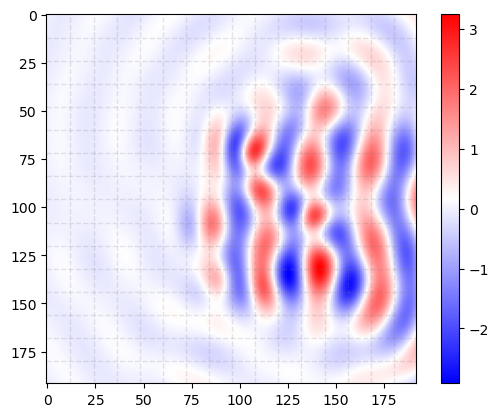

In [18]:
vmin = jnp.real(uscat_regular[:,:,0]).min()
vmax = jnp.real(uscat_regular[:,:,0]).max()

fig, ax = plt.subplots(1)
N_x = uscat_regular.shape[0]
N_l = 2**L
cb = ax.imshow(jnp.real(uscat_regular[:,:,0]), cmap="bwr")
for li in range(1, N_l):
    ax.axvline(N_x * (li/N_l), color="gray", linestyle="dashed", linewidth=1, alpha=0.2)
    ax.axhline(N_x * (li/N_l), color="gray", linestyle="dashed", linewidth=1, alpha=0.2)
fig.colorbar(cb)
plt.show()

In [1]:
vis_idx = 30 # index of leaf to visualize
src_idx = 0 # index of source direction to show

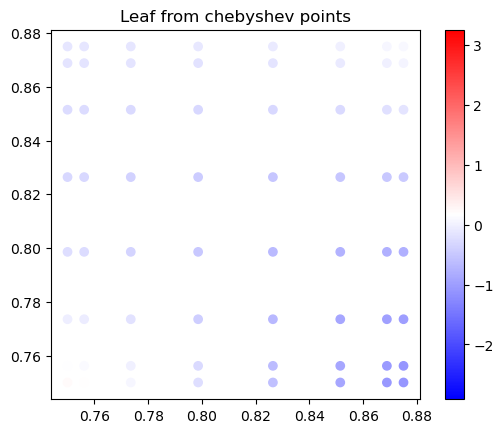

In [20]:
plt.title(f"Leaf from chebyshev points")
# plt.imshow(jnp.real(reordered_uscat_soln[vis_idx, :, src_idx]).reshape(p,p), cmap="bwr")
plt.scatter(
    *reordered_domain_pts_2[vis_idx].T,
    c=jnp.real(reordered_uscat_soln[vis_idx, :, src_idx]),
    cmap="bwr",
    vmin=vmin,
    vmax=vmax,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [21]:
leaf_cheb_pts = chebyshev_points(p)
leaf_unif_n   = 12
leaf_unif_pts = jnp.linspace(-1, 1, leaf_unif_n, endpoint=False)
tmp_interp_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_cheb_pts,
    from_pts_y=leaf_cheb_pts,
    to_pts_x=leaf_unif_pts,
    to_pts_y=leaf_unif_pts,
)
rearrange_idcs = rearrange_indices_ext_int_2D(p)
interp_leaf_cheb_to_unif = tmp_interp_leaf_cheb_to_unif[:, rearrange_idcs]

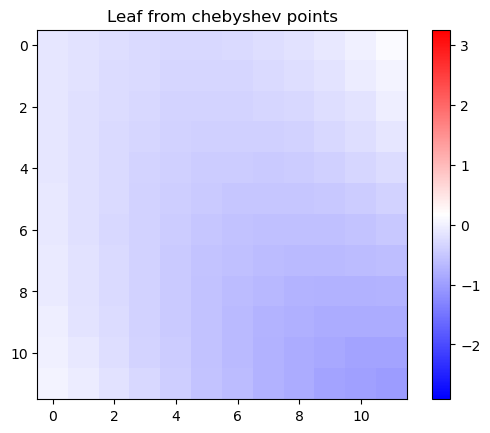

In [22]:
# Evidently something went wrong...
plt.title(f"Leaf from chebyshev points")
plt.imshow(
    jnp.real(interp_leaf_cheb_to_unif @ reordered_uscat_soln[vis_idx, :, src_idx]).reshape(leaf_unif_n, leaf_unif_n),
    cmap="bwr",
    vmin=vmin,
    vmax=vmax,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [23]:
uscat_leaf_unif = uscat_regular.reshape(2**L,12, 2**L,12, source_dirs.shape[0]) \
    .transpose(0,2,1,3,4) \
    .reshape(4**L, 12*12, source_dirs.shape[0])
print(uscat_leaf_unif.shape)

(256, 144, 30)


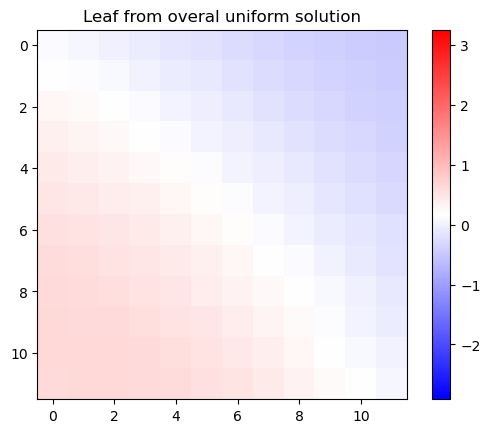

In [24]:
plt.title(f"Leaf from overal uniform solution")
plt.imshow(
    jnp.real(uscat_leaf_unif[vis_idx, :, src_idx].reshape(12,12)),
    cmap="bwr",
    vmin=vmin,
    vmax=vmax,
  )
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

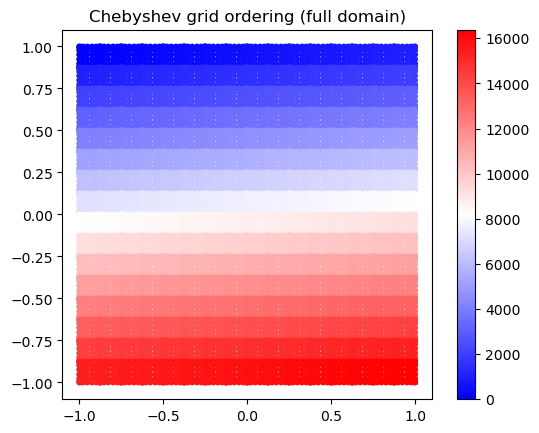

In [25]:
plt.title(f"Chebyshev grid ordering (full domain)")
plt.scatter(*reordered_domain_pts_2.reshape(-1,2)[:].T, s=10, c=jnp.arange(reordered_domain_pts_2.size//2)[:], cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## Try on a single leaf with a known object

In [26]:
leaf_root = DiscretizationNode2D(-1., 1., -1., 1.)
leafp = 12
leaf_domain = Domain(p=leafp, q=leafp-2, root=leaf_root, L=0)

In [27]:
leaf_cheb_x = chebyshev_points(leafp)
leaf_cheb_y = chebyshev_points(leafp) # [::-1]

leaf_cheb_xy = jnp.array(jnp.meshgrid(leaf_cheb_x, leaf_cheb_y, indexing="ij")).transpose(1,2,0)

In [28]:
q_leaf_cheb = q_fn_handle(leaf_cheb_xy * 0.6)

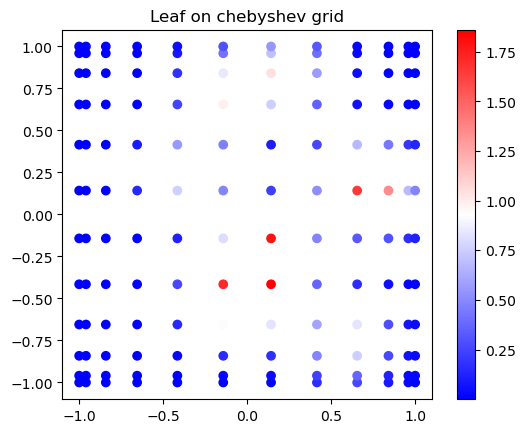

In [29]:
plt.title(f"Leaf on chebyshev grid")
# plt.imshow(jnp.real(reordered_uscat_soln[vis_idx, :, src_idx]).reshape(p,p), cmap="bwr")
plt.scatter(
    *leaf_cheb_xy.reshape(-1,2).T,
    c=jnp.real(q_leaf_cheb.reshape(-1)),
    cmap="bwr",
    # vmin=vmin,
    # vmax=vmax,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [30]:
leaf_unif_n   = 24
leaf_unif_pts = jnp.linspace(-1, 1, leaf_unif_n, endpoint=False)
leaf_unif_xy  = jnp.array(jnp.meshgrid(leaf_unif_pts, leaf_unif_pts, indexing="ij")).transpose(1,2,0)
q_leaf_unif = q_fn_handle(leaf_unif_xy * 0.6)
tmp_interp_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_cheb_x,
    from_pts_y=leaf_cheb_y,
    to_pts_x=leaf_unif_pts,
    to_pts_y=leaf_unif_pts,
)
rearrange_idcs = rearrange_indices_ext_int_2D(leafp)
interp_leaf_cheb_to_unif = tmp_interp_leaf_cheb_to_unif # [:, rearrange_idcs]

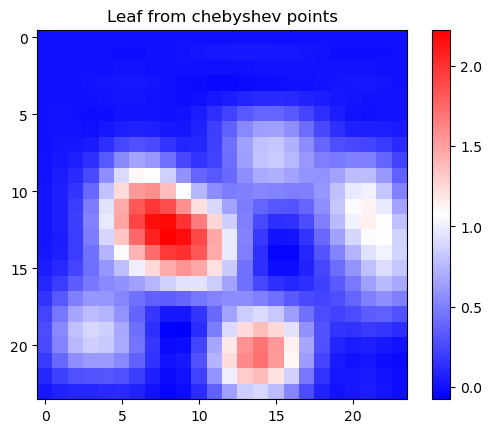

In [31]:
# Evidently I'm doing something wrong...
plt.title(f"Leaf from chebyshev points")
plt.imshow(
    jnp.real(interp_leaf_cheb_to_unif @ q_leaf_cheb.reshape(-1)).reshape(leaf_unif_n, leaf_unif_n),
    cmap="bwr",
    # vmin=vmin,
    # vmax=vmax,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

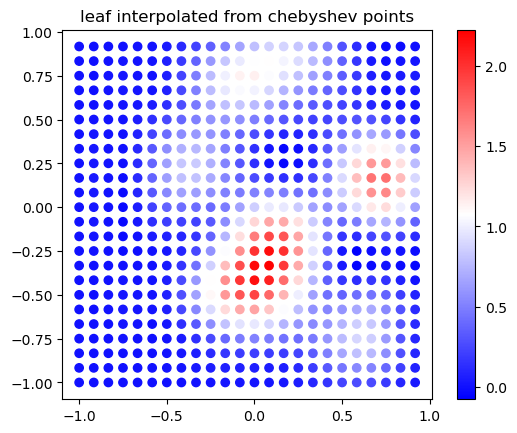

In [32]:
plt.title(f"leaf interpolated from chebyshev points")
# plt.imshow(jnp.real(reordered_uscat_soln[vis_idx, :, src_idx]).reshape(p,p), cmap="bwr")
plt.scatter(
    *leaf_unif_xy.reshape(-1,2).T,
    c=jnp.real(interp_leaf_cheb_to_unif @ q_leaf_cheb.reshape(-1)),
    cmap="bwr",
    # vmin=vmin,
    # vmax=vmax,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [33]:
q_leaf_cheb_alt = q_fn_handle(0.6 * leaf_domain.interior_points)
q_leaf_unif_alt, target_pts = leaf_domain.interp_from_interior_points(
    q_leaf_cheb_alt.reshape(1,-1), # probably will have problems since I haven't re-ordered the points...
    leaf_unif_pts,
    leaf_unif_pts,
)

In [34]:
q_leaf_unif_alt.shape

(24, 24)

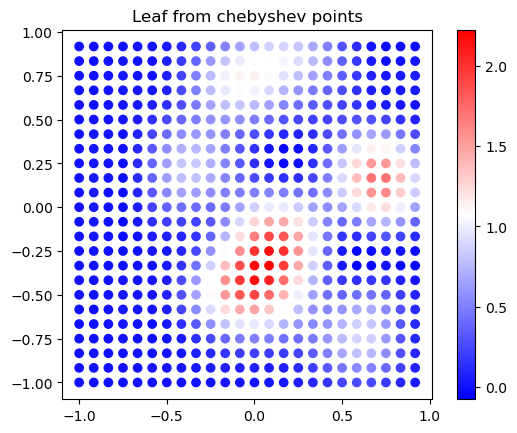

In [35]:
plt.title(f"Leaf from chebyshev points")
# plt.imshow(jnp.real(reordered_uscat_soln[vis_idx, :, src_idx]).reshape(p,p), cmap="bwr")
plt.scatter(
    *target_pts.reshape(-1,2).T,
    c=jnp.real(q_leaf_unif_alt.reshape(-1)),
    cmap="bwr",
    # vmin=vmin,
    # vmax=vmax,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

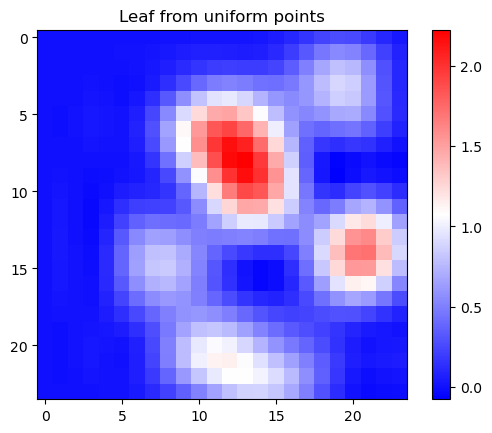

In [36]:
# Evidently something went wrong...
plt.title(f"Leaf from uniform points")
plt.imshow(
    jnp.real(q_leaf_unif_alt),
    cmap="bwr",
    # vmin=vmin,
    # vmax=vmax,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

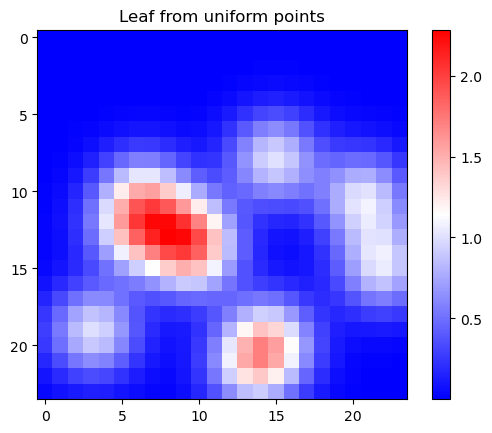

In [37]:
# Evidently something went wrong...
plt.title(f"Leaf from uniform points")
plt.imshow(
    jnp.real(q_leaf_unif),
    cmap="bwr",
    # vmin=vmin,
    # vmax=vmax,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

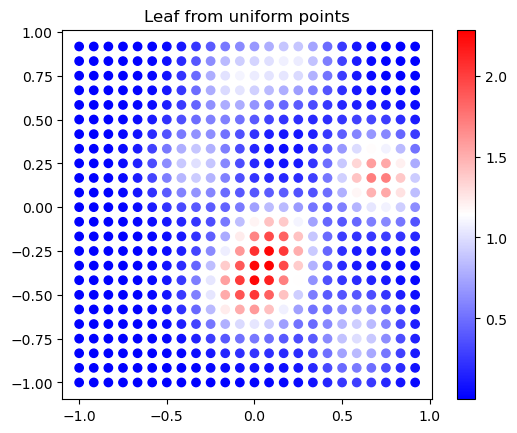

In [38]:
plt.title(f"Leaf from uniform points")
# plt.imshow(jnp.real(reordered_uscat_soln[vis_idx, :, src_idx]).reshape(p,p), cmap="bwr")
plt.scatter(
    *leaf_unif_xy.reshape(-1,2).T,
    c=jnp.real(q_leaf_unif.reshape(-1)), cmap="bwr",
    # vmin=vmin,
    # vmax=vmax,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()